In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
data_orders = pd.read_csv('datasets/data_orders.csv')
data_offers = pd.read_csv('datasets/data_offers.csv')

# Merge the two datasets on 'order_gk'
data = pd.merge(data_orders, data_offers, on='order_gk')

# Convert order_datetime to datetime format
data['order_datetime'] = pd.to_datetime(data['order_datetime'])

# Display the first few rows of the merged data
data.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,2024-04-22 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,2024-04-22 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,2024-04-22 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,2024-04-22 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,2024-04-22 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


In [3]:
# Build the distribution of orders by failure reasons
failure_reasons = {
    'Cancellation Before Driver Assignment': data[data['is_driver_assigned_key'] == 0]['order_status_key'].value_counts().get(4, 0),
    'Cancellation After Driver Assignment': data[data['is_driver_assigned_key'] == 1]['order_status_key'].value_counts().get(4, 0),
    'Order Rejection': data['order_status_key'].value_counts().get(9, 0)
}

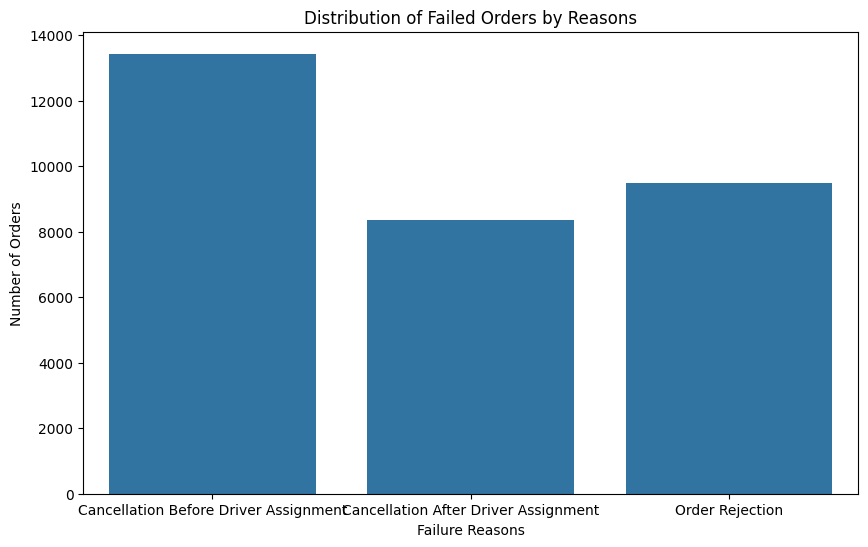

In [4]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(failure_reasons.keys()), y=list(failure_reasons.values()))
plt.xlabel('Failure Reasons')
plt.ylabel('Number of Orders')
plt.title('Distribution of Failed Orders by Reasons')
plt.show()

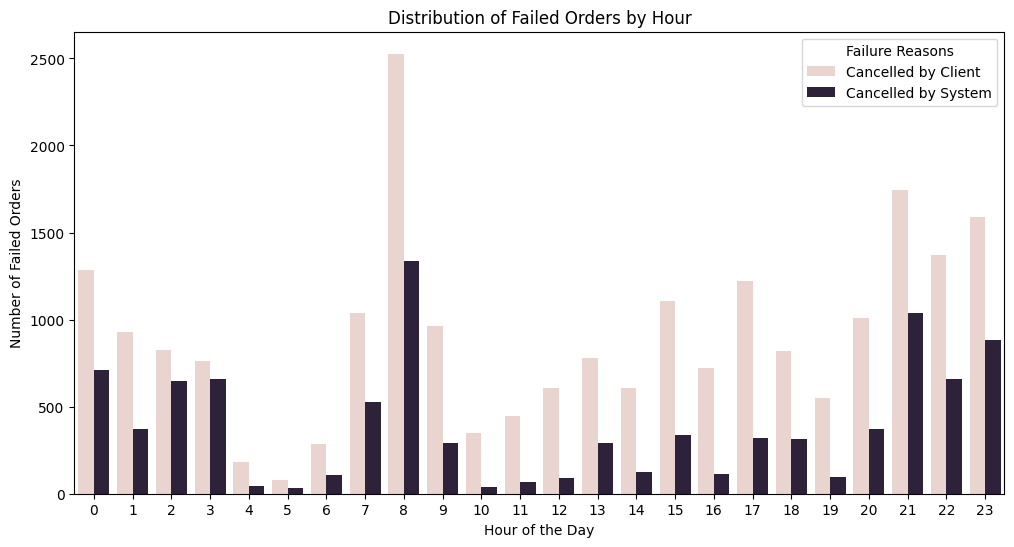

In [5]:
# Plot the distribution of failed orders by hours
data['hour'] = data['order_datetime'].dt.hour
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=data, hue='order_status_key')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Failed Orders')
plt.title('Distribution of Failed Orders by Hour')
plt.legend(title='Failure Reasons', labels=['Cancelled by Client', 'Cancelled by System'])
plt.show()


In [14]:
# Print column names
print(data.columns)


Index(['order_datetime', 'origin_longitude', 'origin_latitude', 'm_order_eta',
       'order_gk', 'order_status_key', 'is_driver_assigned_key',
       'cancellations_time_in_seconds', 'offer_id', 'hour', 'hex_id'],
      dtype='object')


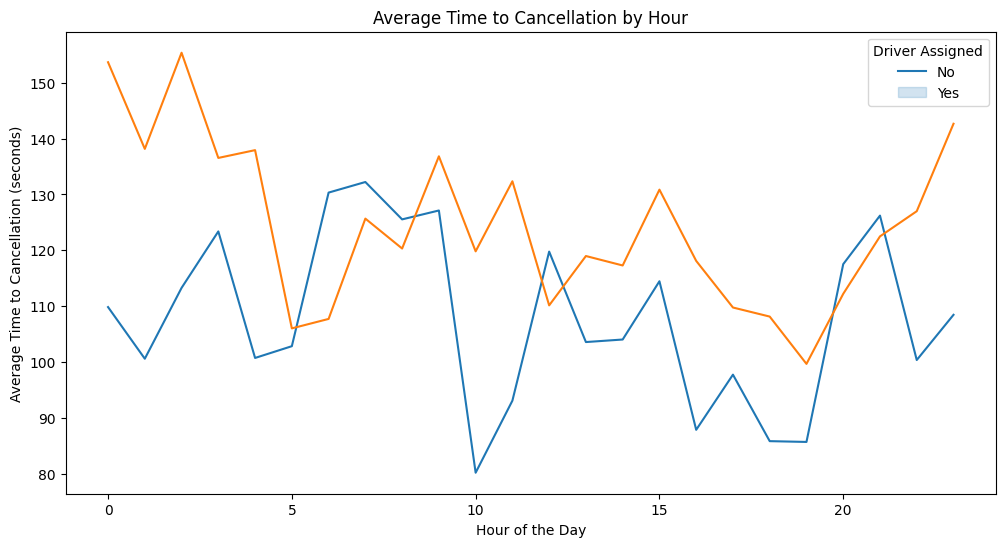

In [15]:
# Remove rows where cancellation_time_in_seconds is null
data_filtered = data.dropna(subset=['cancellations_time_in_seconds'])

# Remove outliers for cancellation_time_in_seconds
Q1 = data_filtered['cancellations_time_in_seconds'].quantile(0.25)
Q3 = data_filtered['cancellations_time_in_seconds'].quantile(0.75)
IQR = Q3 - Q1
data_filtered = data_filtered[(data_filtered['cancellations_time_in_seconds'] >= (Q1 - 1.5 * IQR)) & (data_filtered['cancellations_time_in_seconds'] <= (Q3 + 1.5 * IQR))]

# Calculate the average time to cancellation with and without driver, by the hour
avg_cancel_time = data_filtered.groupby(['hour', 'is_driver_assigned_key'])['cancellations_time_in_seconds'].mean().reset_index()

# Plot the average time to cancellation
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='cancellations_time_in_seconds', hue='is_driver_assigned_key', data=avg_cancel_time)
plt.xlabel('Hour of the Day')
plt.ylabel('Average Time to Cancellation (seconds)')
plt.title('Average Time to Cancellation by Hour')
plt.legend(title='Driver Assigned', labels=['No', 'Yes'])
plt.show()


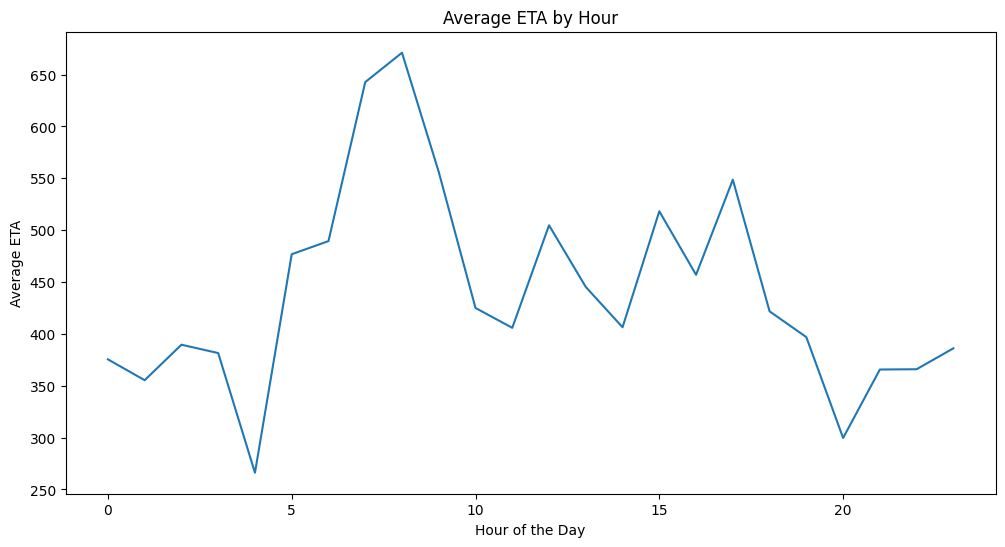

In [8]:
# Plot the distribution of average ETA by hours
avg_eta_by_hour = data.groupby('hour')['m_order_eta'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='m_order_eta', data=avg_eta_by_hour)
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA')
plt.title('Average ETA by Hour')
plt.show()


In [11]:
import h3
import folium

# Calculate hexagon for each order
data['hex_id'] = data.apply(lambda x: h3.geo_to_h3(x['origin_latitude'], x['origin_longitude'], 8), axis=1)

# Calculate order counts per hexagon
hex_counts = data['hex_id'].value_counts().reset_index()
hex_counts.columns = ['hex_id', 'order_count']
total_orders = hex_counts['order_count'].sum()

# Calculate cumulative percentage of orders
hex_counts['cumulative_percentage'] = hex_counts['order_count'].cumsum() / total_orders

# Select hexagons containing 80% of all orders
selected_hexes = hex_counts[hex_counts['cumulative_percentage'] <= 0.8]

# Create a map
m = folium.Map(location=[data['origin_latitude'].mean(), data['origin_longitude'].mean()], zoom_start=11)

# Plot hexagons on the map
for _, row in selected_hexes.iterrows():
    polygon = h3.h3_to_geo_boundary(row['hex_id'])
    folium.Polygon(locations=polygon, fill=True, fill_color='blue', fill_opacity=0.4, color='black', weight=1).add_to(m)

# Display the map
m.save('hex_map.html')
